# Косарев Евгений

Построить графики распределения в спам и не спам множествах следующих признаков:

1)	Количество слов на странице

2)	Средняя длинна слова

3)	Количество слов в заголовке страниц (слова в теге <html><head><title> Some text </title>)

4)	Количество слов в анкорах ссылок (<html><body><a> Some text </a>)

5)	Коэффициент сжатия

Нужно посчитать статистику минимум по трем признакам и обязательно сделать для 1-го и 2-го признаков

И отправить первое решение в соревнование https://kaggle.com/join/antispam_infopoisk
На основании одного из указанных выше признаков попытаться разделить мн-во, так чтобы score в соревновании был больше 0.55

При выполнении всех этих условия в течении семинара +1 балл к ДЗ

Описание ДЗ и правил выставления за него баллов в https://inclass.kaggle.com/c/antispam-infopoisk  
Сроки ДЗ уточнить у преподователя - обычно 2 недели

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import base64
import gzip
import zlib

from collections import namedtuple

from importlib import reload

%matplotlib inline
import matplotlib.pyplot as plt

In [10]:
type(1) 

int

In [11]:
TRACE_NUM = 1000
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items {}".format(items_num))
        
def trace_worker(items_num, worker_id, trace_num=TRACE_NUM):
    if type(items_num) != int or type(trace_num) != int:
        pass
    worker_id = int(worker_id)
    if items_num % trace_num == 0: 
        logging.info("Complete items {} in worker_id {}".format(str(items_num), str(worker_id)))

### Утилиты

#### Декораторы

In [12]:
def to_utf8(text):
    if isinstance(text, str): text = text.encode('utf8')
    return text

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

#P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [13]:
from html.parser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = []
        self._link = []
        self._in_title = False
        self._in_link = False
        self.script_cnt = 0

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            if self._in_title:
                self._title.append(text + ' ')
            if self._in_link:
                self._link.append(text + ' ')
            self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True
        elif tag == 'a':
            self._in_link = True
        elif tag == 'script':
            self.script_cnt +=1
            
    def handle_endtag(self, tag):
        if tag == 'title':
            self._in_title = False
        elif tag == 'a':
            self._in_link = False

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip()
    
    def title(self):
        return ''.join(self._title).strip()
    
    def link(self):
        return ''.join(self._link).strip()
    
    def script(self):
        return self.script_cnt

In [118]:
def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(str(text))
    return parser.text(), parser.title(), parser.link(), parser.script()

#### Извлечение текста при помощи дополнительных библиотек

In [14]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

#### Методы для токенизации текста

In [16]:
@convert2lower
def easy_tokenizer(text):
    word = ''
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = ''
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

@convert2lower
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

#### Рассчет финальных метрик

In [119]:
def calc_features(url, html_data):
    text, title, link, scripts = html2text_parser(html_data)
    tmp = []
    
    tmp.append(tokenizer(text.lower()))
    tmp.append(tokenizer(title.lower()))
    tmp.append(tokenizer(link.lower()))
    tmp.append(scripts)
    
    script = tmp[-1]
    words, title, link = map(list, tmp[:-1])
    
    word_len_mean = 0.
    for el in words:
        avg_word_len += len(word)
    avg_word_len /= len(words)
    utf_made = to_utf8(html_data)
    comressed = zlib.compress(utf_made)
    compress_coef = len(comressed)/len(html_data)
    
    return [len(words), word_len_mean, len(title), len(link), script, compress_coef, tmp[0]]

In [23]:
test_html_data = u'''
<html>
<title> Заголовок Ololo </title>
спам 1 2 3
<body> <a>Текст ссылки </a> 
<a>Текст ссылки 1 </a> 
</body>
</html>
'''
test_url = 'http://ololo'
test_features = calc_features(test_url, test_html_data)
print (test_features[6])

Заголовок Ololo спам 1 2 3 Текст ссылки Текст ссылки 1


In [24]:
print(type(test_html_data))

<class 'str'>


In [26]:
from multiprocessing import Process, Queue
DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

WORKER_NUM = 10
        
def load_csv_worker(input_file_name, calc_features_f, worker_id, res_queue):    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()

        for i, line in enumerate(input_file):
            trace_worker(i, worker_id)
            if i % WORKER_NUM != worker_id: continue
            tmp = line.strip()
            parts1 = tmp.decode().split('\t')
            parts = []
            for i in parts1:
                parts.append(str(i))
            #a = parts
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            features = calc_features_f(url, str(html_data))            
            res_queue.put(DocItem(url_id, mark, url, features))
                
        trace_worker(777, worker_id, 1)
    res_queue.put(None)
        
def load_csv_multiprocess(input_file_name, calc_features_f):
    processes = []
    res_queue = Queue()    
    for i in range(WORKER_NUM):
        process = Process(target=load_csv_worker, args=(input_file_name, calc_features_f, i, res_queue))
        processes.append(process)
        process.start()
        
    complete_workers = 0
    while complete_workers != WORKER_NUM:
        item = res_queue.get()
        if item is None:
            complete_workers += 1
        else:
            yield item
        
    for process in processes: process.join()

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

# Код ниже собран в классификатор

In [117]:
class Classifier:
        
    def __init__(self, n_jobs=-1, n_estimators = 450, max_depth = 5, C = 1000):
        
        from sklearn.linear_model import LogisticRegression
        from sklearn.linear_model import LinearRegression
        import numpy as np
        import pandas as pd
        from sklearn.feature_extraction.text import TfidfVectorizer
        from nltk.corpus import stopwords
        import xgboost as xgb
        from sklearn.svm import SVR
        import nltk
        
        nltk.download('stopwords')
        stop_words = stopwords.words('russian')
        stop_words.extend([u'в',u'так', u'к', u'—', u'с', u'быть', u'вот', u'это', u'как',  u'к', u'на'\
                           u'ж', u'ли', u'а', u'что', ])
        
        self.train_booster = xgb.XGBClassifier(n_jobs=n_jobs, max_depth=max_depth, n_estimators=n_estimators)
        self.train_log_reg = LogisticRegression(C=C, n_jobs=n_jobs)
        self.train_svr = SVR()
        self.train_vect = TfidfVectorizer(ngram_range=(1,3), min_df=5, stop_words=stop_words)
        
        self.decision_rule = LinearRegression()
        
    def convertation(text):
        regex = re.compile(u'[^a-zA-Zа-яА-Я]')
        return regex.sub(u' ', text)
    
    def predict(self, test_docs):
        ind = len(test_docs[0]) - 1
        test_prep = [self.convertation(doc.features[ind].lower()) for doc in test_docs]
        X_test_prep = self.train_vect.transform(test_prep)
        
        train_booster_res = self.train_booster.predict_proba(X_test_prep)
        train_log_reg_res = self.train_log_reg.predict_proba(X_test_prep)
        train_svr_res = self.train_svr.predict(X_test_prep)
        
        a = {'Id':[], 'Prediction' :[]}
        idx = 0
        for doc in test_docs:
            a['Id'].append(doc[0])
            tmp = 0
            pred = self.decision_rule.predict(np.array([train_booster_res[idx][0], train_log_reg_res[idx][0],\
                                                   train_svr_res[idx]]).reshape(1, -1))
            if pred > 0.5:
                tmp = 1
            a['Prediction'].append(tmp)
            idx += 1
        return pd.DataFrame(a)
        
    def fit(self, train_docs):
        texts_target = [int(doc.is_spam) for doc in train_docs if doc.features != None]
        
        ind = len(train_docs[0]) - 1
        prep_text = [self.convertation(doc.features[6].lower()) for doc in train_docs]
        self.train_vect.fit(prep_text)
        X_vec_prep = self.train_vect.transform(prep_text)
        
        self.train_svr.fit(X_vec_prep, texts_target)
        self.train_booster.fit(X_vec_prep, texts_target)
        self.train_log_reg.fit(X_vec_prep, texts_target)
        
        train_gb = self.train_booster.predict_proba(X_vec_prep)
        train_lr = self.train_log_reg.predict_proba(X_vec_prep)
        train_svr = self.train_svr.predict(X_vec_prep)
        
        X_final = {'1': train_gb[:, 0], 
           '2': train_lr[:, 0], 
           '3': train_svr
        }
        X_final = pd.DataFrame(X_final)
        
        self.decision_rule.fit(X_final, texts_target)

In [ ]:
my_class = Classifier()
my_class.fit(train_docs)
res = my_class.predict(test_docs)
res

# Сам код

In [29]:
%%time

train_docs = list(load_csv_multiprocess('kaggle_train_data_tab.csv.gz', calc_features))

20:42:22 INFO:Complete items 0 in worker_id 1
20:42:22 INFO:Complete items 0 in worker_id 0
20:42:22 INFO:Complete items 0 in worker_id 2
20:42:22 INFO:Complete items 0 in worker_id 3
20:42:22 INFO:Complete items 0 in worker_id 4
20:42:22 INFO:Complete items 0 in worker_id 5
20:42:22 INFO:Complete items 0 in worker_id 6
20:42:22 INFO:Complete items 0 in worker_id 7
20:42:22 INFO:Complete items 0 in worker_id 8
20:42:22 INFO:Complete items 0 in worker_id 9
20:42:31 INFO:Complete items 1000 in worker_id 6
20:42:31 INFO:Complete items 1000 in worker_id 3
20:42:31 INFO:Complete items 1000 in worker_id 5
20:42:32 INFO:Complete items 1000 in worker_id 2
20:42:32 INFO:Complete items 1000 in worker_id 8
20:42:32 INFO:Complete items 1000 in worker_id 4
20:42:32 INFO:Complete items 1000 in worker_id 1
20:42:33 INFO:Complete items 1000 in worker_id 9
20:42:34 INFO:Complete items 1000 in worker_id 0
20:42:36 INFO:Complete items 1000 in worker_id 7
20:42:39 INFO:Complete items 2000 in worker_id 2
2

CPU times: user 1.05 s, sys: 751 ms, total: 1.8 s
Wall time: 1min 11s


In [59]:
%%time

test_docs = list(load_csv_multiprocess('kaggle_test_data_tab.csv.gz', calc_features))

20:56:46 INFO:Complete items 0 in worker_id 0
20:56:46 INFO:Complete items 0 in worker_id 1
20:56:46 INFO:Complete items 0 in worker_id 2
20:56:46 INFO:Complete items 0 in worker_id 3
20:56:46 INFO:Complete items 0 in worker_id 4
20:56:46 INFO:Complete items 0 in worker_id 5
20:56:46 INFO:Complete items 0 in worker_id 6
20:56:46 INFO:Complete items 0 in worker_id 7
20:56:46 INFO:Complete items 0 in worker_id 8
20:56:46 INFO:Complete items 0 in worker_id 9
20:56:56 INFO:Complete items 1000 in worker_id 2
20:56:56 INFO:Complete items 1000 in worker_id 1
20:56:57 INFO:Complete items 1000 in worker_id 8
20:56:57 INFO:Complete items 1000 in worker_id 9
20:56:57 INFO:Complete items 1000 in worker_id 0
20:56:58 INFO:Complete items 1000 in worker_id 7
20:56:59 INFO:Complete items 1000 in worker_id 4
20:56:59 INFO:Complete items 1000 in worker_id 3
20:56:59 INFO:Complete items 1000 in worker_id 5
20:57:04 INFO:Complete items 1000 in worker_id 6
20:57:06 INFO:Complete items 2000 in worker_id 0
2

20:59:48 INFO:Complete items 16000 in worker_id 9
20:59:49 INFO:Complete items 777 in worker_id 3
20:59:49 INFO:Complete items 777 in worker_id 9
20:59:50 INFO:Complete items 16000 in worker_id 5
20:59:51 INFO:Complete items 777 in worker_id 5
20:59:52 INFO:Complete items 15000 in worker_id 1
20:59:52 INFO:Complete items 15000 in worker_id 6
20:59:55 INFO:Complete items 16000 in worker_id 4
20:59:55 INFO:Complete items 777 in worker_id 4
20:59:59 INFO:Complete items 16000 in worker_id 1
20:59:59 INFO:Complete items 777 in worker_id 1
21:00:01 INFO:Complete items 16000 in worker_id 6
21:00:01 INFO:Complete items 777 in worker_id 6


CPU times: user 3.03 s, sys: 2.05 s, total: 5.08 s
Wall time: 3min 15s


In [30]:
texts_target = [int(doc.is_spam) for doc in train_docs if doc.features != None]

In [31]:
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import xgboost as xgb
from sklearn.svm import SVR

In [32]:
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('russian')
stop_words.extend([u'в',u'так', u'к', u'—', u'с', u'быть', u'вот', u'это', u'как',  u'к', u'на'\
                           u'ж', u'ли', u'а', u'что', ])

def prep(text):
    regex = re.compile(u'[^a-zA-Zа-яА-Я]')
    return regex.sub(u' ', text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/evgenij_kosarev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [36]:
prep_text = [prep(doc.features[6].lower()) for doc in train_docs]
test_prep = [prep(doc.features[6].lower()) for doc in test_docs]

In [37]:
vectorizer_prep = TfidfVectorizer(ngram_range=(1,3), min_df=5, stop_words=stop_words)

In [120]:
%%time 
vectorizer_prep.fit(prep_text)

KeyboardInterrupt: 

In [42]:
%%time 
X_vec_prep = vectorizer_prep.transform(prep_text)

CPU times: user 2min, sys: 233 ms, total: 2min 1s
Wall time: 2min 1s


In [51]:
gb_prep = xgb.XGBClassifier(n_jobs=-1, max_depth=5, n_estimators=450)

In [52]:
lr_prep = LogisticRegression(C=1000, n_jobs=-1)

In [53]:
svr_prep = SVR()

In [54]:
%time svr_prep.fit(X_vec_prep, texts_target)

/home/evgenij_kosarev/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 1min 42s, sys: 57.7 ms, total: 1min 42s
Wall time: 1min 42s


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [55]:
%time gb_prep.fit(X_vec_prep, texts_target)

CPU times: user 2min 36s, sys: 27.8 ms, total: 2min 36s
Wall time: 2min 36s


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=450, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [56]:
%time lr_prep.fit(X_vec_prep, texts_target)

/home/evgenij_kosarev/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/evgenij_kosarev/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


CPU times: user 2.81 s, sys: 58 µs, total: 2.81 s
Wall time: 2.81 s


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [61]:
X_test_prep = vectorizer_prep.transform(test_prep)

In [62]:
train_gb = gb_prep.predict_proba(X_vec_prep)
train_lr = lr_prep.predict_proba(X_vec_prep)
train_svr = svr_prep.predict(X_vec_prep)

In [65]:
from sklearn.linear_model import LinearRegression
import pandas as pd

In [66]:
X_final = {'1': train_gb[:, 0], 
           '2': train_lr[:, 0], 
           '3': train_svr
}
X_final = pd.DataFrame(X_final)

In [67]:
X_final.shape

(7044, 3)

In [77]:
decision_rule = SVR()

In [78]:
decision_rule.fit(X_final, texts_target)

/home/evgenij_kosarev/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [70]:
gb_prep_proba = gb_prep.predict_proba(X_test_prep)

In [71]:
lr_prep_proba = lr_prep.predict_proba(X_test_prep)

In [72]:
svr_prep_proba = svr_prep.predict(X_test_prep)

In [79]:
a = {'Id':[], 'Prediction' :[]}
pd.DataFrame(a)

,Id,Prediction


In [80]:
idx = 0
for doc in test_docs:
    a['Id'].append(doc[0])
    tmp = 0
    pred = decision_rule.predict(np.array([gb_prep_proba[idx][0], lr_prep_proba[idx][0], svr_prep_proba[idx]]).reshape(1, -1))
    if pred > 0.5:
        tmp = 1
    a['Prediction'].append(tmp)
    idx += 1

In [81]:
pd.DataFrame(a)

,Id,Prediction
0,-9219333997282093076,1
1,-9216796593526314243,1
2,-9216634615606576667,0
3,-9215403080479774736,1
4,-9203015042136285465,0
...,...,...
16034,9181885161689002993,1
16035,9193662184030370712,1
16036,9200261338537716779,0
16037,9210495629123185419,1


In [82]:
pd.DataFrame(a).to_csv('my_sumbission_6.csv', index = False)

# Графики

/home/evgenij_kosarev/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  after removing the cwd from sys.path.
/home/evgenij_kosarev/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # Remove the CWD from sys.path while we load stuff.
/home/evgenij_kosarev/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()


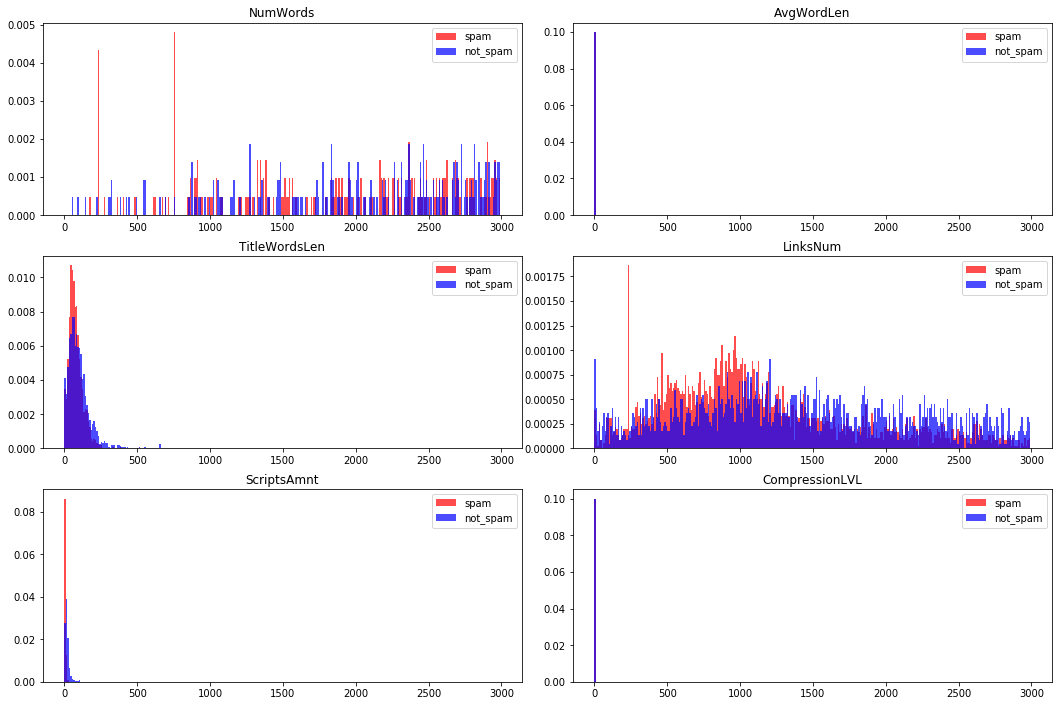

In [114]:
names = ['NumWords', "AvgWordLen", "TitleWordsLen", "LinksNum", "ScriptsAmnt", "CompressionLVL"]

fig1, axs = plt.subplots(3, 2, figsize=(15, 10), constrained_layout=True)
fig1.tight_layout(pad = 2.)
for i in range(6):
    plt.subplot(3, 2, i + 1)
    is_spam_data = [doc.features[i] for doc in train_docs if doc[1] == True]
    not_spam_data = [doc.features[i] for doc in train_docs if doc[1] == False]
    bins = range(0,3000,10)
    plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
    plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
    plt.title(names[i])
    plt.legend()
plt.show()